In [282]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
# import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn import svm
# from sklearn.ensemble import RandomForestClassifier

In [283]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

## **1. 결측치 제거** 

- occpy_type 제거 이유
    - NULL 값을 보여줘야한다. -> R
- FLAG_MOBIL
  - 모두가 1인것을 보여줘야한다

In [269]:
train=train.drop(['index','occyp_type','FLAG_MOBIL'], axis=1)
test=test.drop(['index','occyp_type','FLAG_MOBIL'], axis=1)

In [270]:
train["DAYS_BIRTH"] = abs(train["DAYS_BIRTH"])
train["DAYS_EMPLOYED"] = abs(train["DAYS_EMPLOYED"])
train["begin_month"] = abs(train["begin_month"])

In [271]:
import numpy as np

# 로그 변환할 특성 선택
skewed_features = ['income_total', 'DAYS_EMPLOYED']

# 0이나 음수 값이 없는 경우에만 로그 변환 적용
for feature in skewed_features:
    if (train[feature] > 0).all():
        train[feature] = np.log(train[feature])

## **2. Binary variables**

- gender, car, reality, income_type, edu_type, family_type, house_type

In [272]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

bin = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type']
for i in bin:
    print(train[i].value_counts())
    s = encoder.fit_transform(train[i])
    train.loc[:,i] = s
    print(train[i].value_counts())
    print('-'*10)
    train[i] = pd.to_numeric(train[i])

gender
F    17697
M     8760
Name: count, dtype: int64
gender
0    17697
1     8760
Name: count, dtype: int64
----------
car
N    16410
Y    10047
Name: count, dtype: int64
car
0    16410
1    10047
Name: count, dtype: int64
----------
reality
Y    17830
N     8627
Name: count, dtype: int64
reality
1    17830
0     8627
Name: count, dtype: int64
----------
income_type
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: count, dtype: int64
income_type
4    13645
0     6202
1     4449
2     2154
3        7
Name: count, dtype: int64
----------
edu_type
Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: count, dtype: int64
edu_type
4    17995
1     7162
2     1020
3      257
0       23
Name: count, dtype: int64
----------
family_type
Marrie

In [252]:
for i in bin:
    s = encoder.fit_transform(test[i])
    test.loc[:,i] = s
    test[i] = pd.to_numeric(test[i])

## 3. Modeling

In [73]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 16) (26457, 1) (10000, 16)


#### Logistic

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 46)

clf= LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred) #0.6413454270597128

0.6415418610360913

#### XGB

In [233]:
from xgboost import XGBClassifier
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 46)
clf=XGBClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred) #0.7031368102796675(로그 변환), 0.7050594097355308(이상치 제거), #????0.7153488372093023

0.7153488372093023

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

### Modeling2

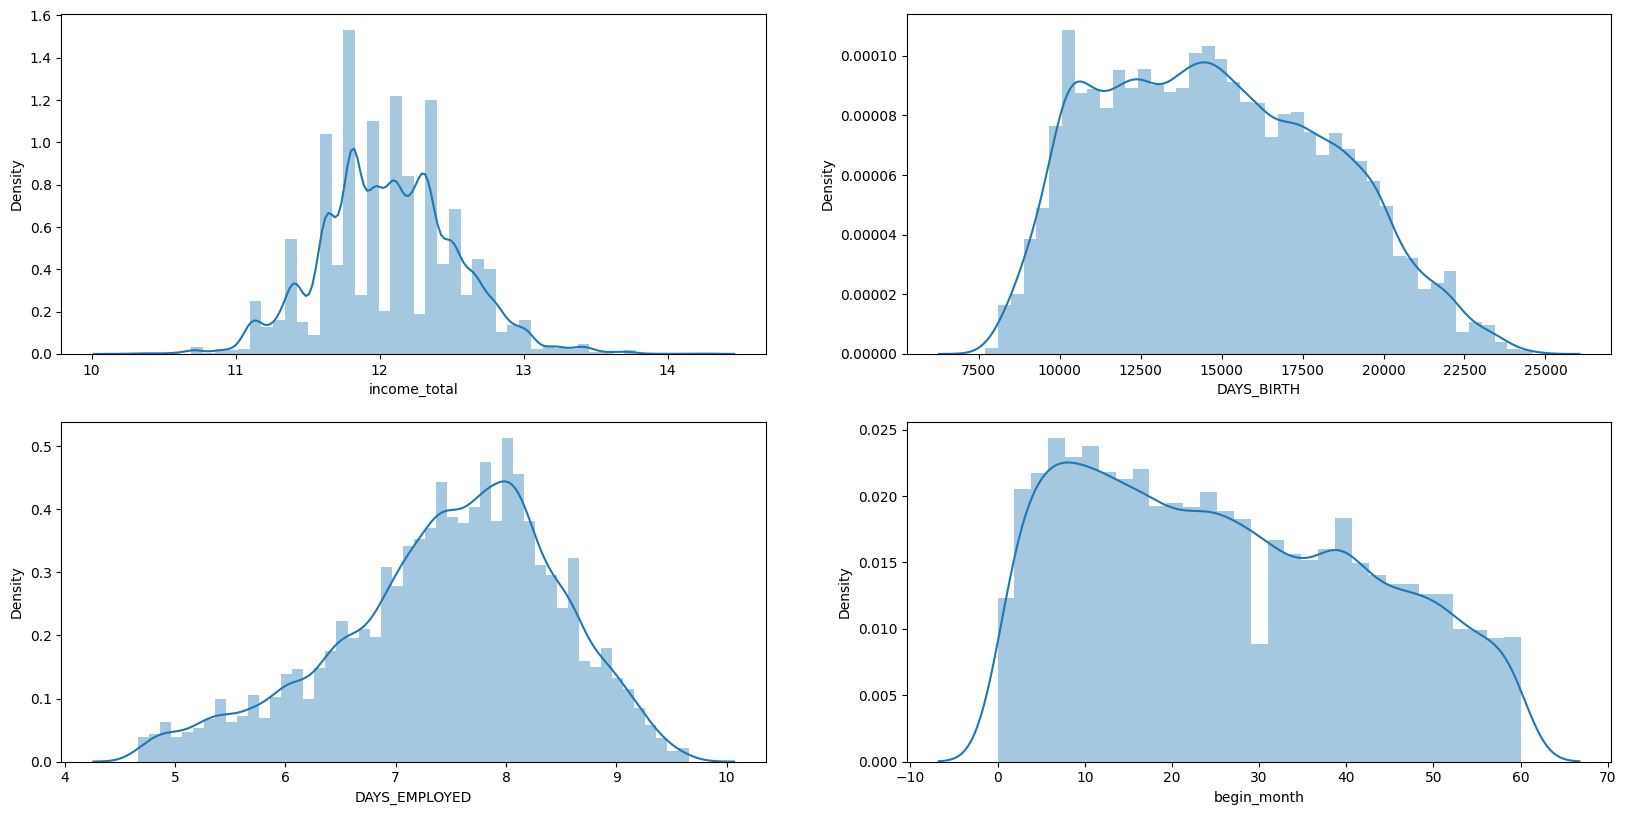

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month']
plt.figure(figsize = (20,15))
for i in range(4):
    plt.subplot(3,2,i+1)
    sns.distplot(train[columns[i]])
plt.show()

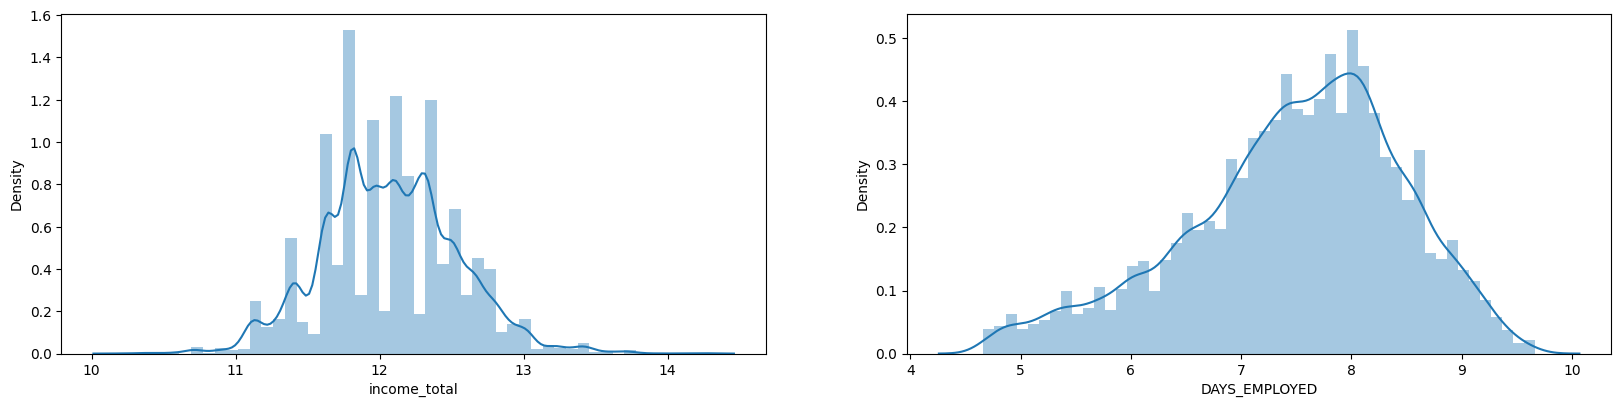

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = skewed_features
plt.figure(figsize = (20,15))
for i in range(2):
    plt.subplot(3,2,i+1)
    sns.distplot(train[columns[i]])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x13998f710>,
 'caps': [<matplotlib.lines.Line2D at 0x13810e050>,
 'boxes': [<matplotlib.lines.Line2D at 0x13998eb50>,
 'medians': [<matplotlib.lines.Line2D at 0x13810f010>,
 'fliers': [<matplotlib.lines.Line2D at 0x13810dc50>,
 'means': []}

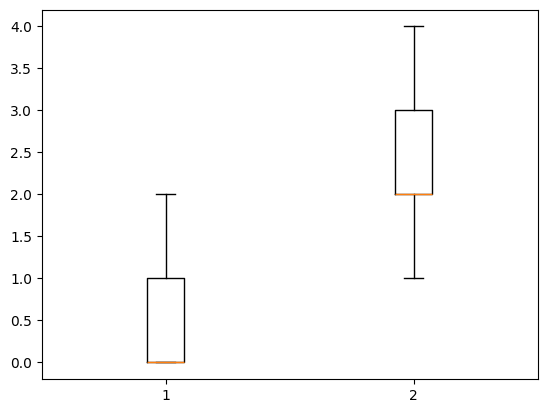

In [189]:
# child_num과 family_size의 박스플롯
plt.boxplot(x=train[['child_num','family_size']])

In [253]:
test = train.copy()

In [276]:
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train

candidate = ["family_size",'child_num','DAYS_EMPLOYED']
# candidate = ["child_num","income_total","DAYS_BIRTH","DAYS_EMPLOYED","family_size","begin_month"]
for cand in candidate:  
    train = remove_outlier(train,cand)
    

outlier의 수 :  350
outlier의 수 :  19
outlier의 수 :  4589


In [268]:
train[["child_num","family_size","credit"]].corr()

,child_num,family_size,credit
child_num,1.000000,0.890530,0.004081
family_size,0.890530,1.000000,0.008227
credit,0.004081,0.008227,1.000000


In [277]:
train[["child_num","family_size","credit"]].corr()

,child_num,family_size,credit
child_num,1.000000,0.878134,0.003536
family_size,0.878134,1.000000,0.006079
credit,0.003536,0.006079,1.000000


In [285]:
train['person'] = train["family_size"] - train["child_num"]

In [286]:
train[["person","credit"]].corr()

,person,credit
person,1.000000,0.010627
credit,0.010627,1.000000


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        0.0000e+00, 6.1200e+03, 0.0000e+00, 0.0000e+00, 2.0331e+04]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

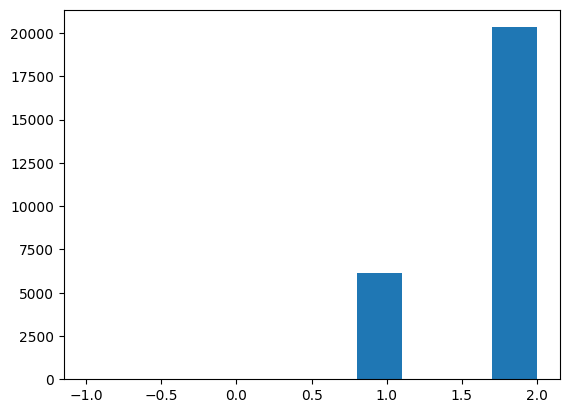

In [287]:
plt.hist(train['person'])

In [291]:
train['child_num'].value_counts()

child_num
0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: count, dtype: int64

In [236]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [237]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218495,0,1,1,2,13899,8.457231,0,0,0,2.0,6.0,1.0
1,0,0,1,1,12.419166,0,4,0,1,11380,7.339538,0,0,1,3.0,5.0,1.0
2,1,1,1,0,13.017003,4,1,1,1,19087,8.397057,0,1,0,2.0,22.0,2.0
3,0,0,1,0,12.218495,0,4,1,1,15088,7.645876,0,1,0,2.0,37.0,0.0
4,0,1,1,0,11.967181,2,1,1,1,15037,7.652071,0,0,0,2.0,26.0,2.0


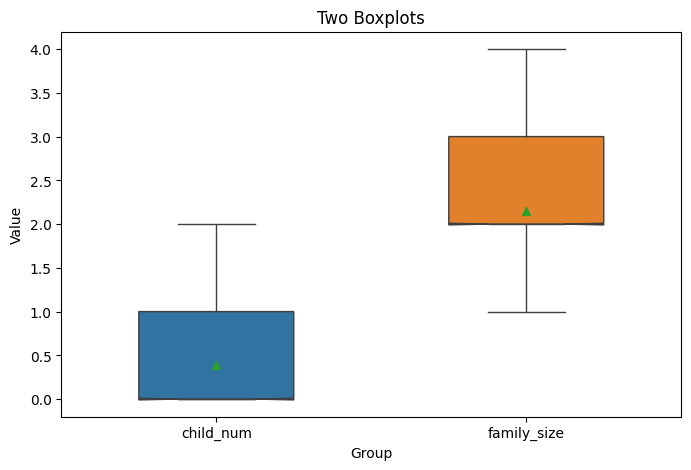

In [190]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=[train['child_num'], train['family_size']], width=0.5, notch=True, showmeans=True)
plt.title('Two Boxplots')
plt.xlabel('Group')
plt.ylabel('Value')
plt.show()

<Axes: >

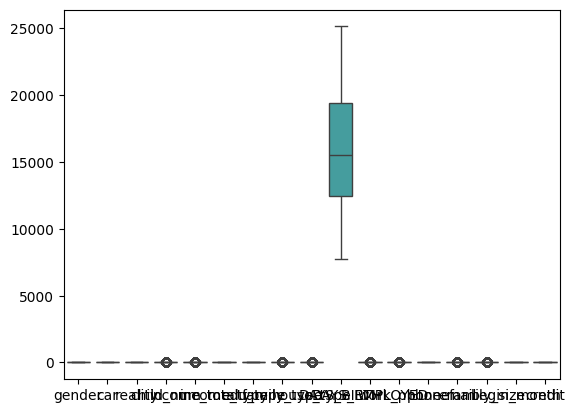

In [154]:
sns.boxplot(data=train)

In [156]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,12.218495,0,1,1,2,13899,8.457231,0,0,0,2.0,6.0,1.0
1,0,0,1,1,12.419166,0,4,0,1,11380,7.339538,0,0,1,3.0,5.0,1.0
2,1,1,1,0,13.017003,4,1,1,1,19087,8.397057,0,1,0,2.0,22.0,2.0
3,0,0,1,0,12.218495,0,4,1,1,15088,7.645876,0,1,0,2.0,37.0,0.0
4,0,1,1,0,11.967181,2,1,1,1,15037,7.652071,0,0,0,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,12.323856,2,4,1,1,12079,7.592870,0,0,0,4.0,2.0,1.0
26453,0,0,1,1,12.100712,4,1,2,1,15291,7.813996,0,0,0,2.0,47.0,2.0
26454,0,1,0,0,12.586220,4,4,0,5,10082,7.608374,0,0,0,2.0,25.0,2.0
26455,1,0,1,0,12.049419,4,2,3,1,10145,4.672829,0,0,0,1.0,59.0,2.0


In [ ]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
# train['income_type']=label_encoder.fit_transform(train['income_type'])
# test['income_type']=label_encoder.transform(test['income_type'])
# ########################################################################
# train['edu_type']=label_encoder.fit_transform(train['edu_type'])
# test['edu_type']=label_encoder.transform(test['edu_type'])
# ########################################################################
# train['family_type']=label_encoder.fit_transform(train['family_type'])
# test['family_type']=label_encoder.transform(test['family_type'])
# ########################################################################
# train['house_type']=label_encoder.fit_transform(train['house_type'])
# test['house_type']=label_encoder.transform(test['house_type'])
# ########################################################################
# train['income_total']=label_encoder.fit_transform(train['income_total'])
# test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

# **[데이터 모델링]**

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)